In [1]:
import collections
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import pyLDAvis
import random
import scipy.sparse
import sys
import time

from gensim.models.coherencemodel import CoherenceModel
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from tmtoolkit.topicmod.evaluate import metric_coherence_gensim

/home/olam/anaconda3/lib/python3.8/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [2]:
class FakedGensimDict:
    """
    Locally made class for `~gensim.corpora.dictionary.Dictionary`
    """
    def __init__(self, data):
        if not isinstance(data, dict):
            raise ValueError('`data` must be an instance of `dict`')

        self.id2token = data
        self.token2id = {v: k for k, v in data.items()}

    @staticmethod
    def from_vocab(vocab):
        return FakedGensimDict(dict(zip(range(len(vocab)), vocab)))

In [3]:
conf = SparkConf().setMaster("local").setAll([
     ('spark.executor.memory', '8g'),
     ('spark.driver.memory','8g'),
     ('spark.driver.maxResultSize', '0')
    ])

# create the session
spark = SparkSession.builder.config(conf=conf).getOrCreate()

# create the context
sc = spark.sparkContext

/home/olam/anaconda3/lib/python3.8/site-packages/pyspark/sql/context.py:75: DeprecationWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [4]:
def remove_zero_rows(M):
    '''Function that removes all rows from sparse matrix M that contains only zero.'''
    num_nonzeros = np.diff(M.indptr)
    return M[num_nonzeros != 0]

In [5]:
# Load data
S = scipy.sparse.load_npz('/dlabdata1/youtube_large/olam/data/view10000_sub100000/csr_matrices_100000sub/S_final_tok100vid.npz')

# Load set of videos to consider
with open('/dlabdata1/youtube_large/olam/data/view10000_sub100000/sorted_idx_relevant_vid_top20_sub100000.pickle', 'rb') as f:
    sorted_idx_relevant_vid_top20 = pickle.load(f)
f.close()

S_20 = S[sorted_idx_relevant_vid_top20,:]
S_20 = remove_zero_rows(S_20)

In [6]:
# Load dictionnary of words
with open('/dlabdata1/youtube_large/olam/data/view10000_sub100000/id2word_tok100vid_sub100000.pickle', 'rb') as f:
    id2word = pickle.load(f)
f.close()

In [ ]:
describe_topics = spark.read.json('/dlabdata1/youtube_large/olam/data/view10000_sub100000/LDA_models/top20/describe_topics_75_iter1000_tok100vid.json')

# Print topics
for row in describe_topics.sort('topic').rdd.collect():
    print('Topic ' + str(row.topic) + ': ')
    term_weights = row.termWeights
    for i, token_id in enumerate(row.termIndices):
        print('   With weight of ' + str(term_weights[i]) + ' : ' + id2word[token_id] )
        if i >= 10:
            break

## Computing c_v coherence of a topic model

In [ ]:
topics = []

for row in describe_topics.sort('topic').rdd.collect():
    tokenized_topic = []
    for i, token_id in enumerate(row.termIndices):
        tokenized_topic.append(id2word[token_id])
        if i > 5:
            break
    topics.append(tokenized_topic)

In [ ]:
describe_topics = describe_topics.sort('topic')

In [ ]:
vocabSize = S_20.shape[1]

In [ ]:
topic_word_dist = []

for row in describe_topics.collect():
    termIndices = row['termIndices']
    termWeights = row['termWeights']
    
    word_dist = {}
    for i in range(vocabSize):
        word_dist[termIndices[i]] = termWeights[i]
        
    word_dist_ordered = collections.OrderedDict(sorted(word_dist.items()))
    topic_word_dist.append(list(word_dist_ordered.values()))

In [ ]:
topic_word_dist = np.matrix(topic_word_dist)

In [ ]:
vocab = list(id2word.values())

In [ ]:
vocab = np.array(vocab)

In [ ]:
texts = []

In [ ]:
for i in range(S_20.shape[0]):
    token_indices = list(S_20.getrow(i).nonzero()[1])
    tokens = []
    
    for token_indice in token_indices:
        tokens.append(id2word[token_indice])
    texts.append(tokens)

In [ ]:
topic_word_dist.shape

In [ ]:
coherence_score = metric_coherence_gensim(measure='c_v',
                                          topic_word_distrib=topic_word_dist,
                                          vocab=vocab,
                                          texts=texts)

In [ ]:
coherence_model = CoherenceModel(topics=topics,
                                 corpus=S_20,
                                 dictionary=FakedGensimDict.from_vocab(vocab),
                                 texts=texts,
                                 coherence='c_v')

In [ ]:
coherence_model.get_coherence() ## with 5 words to describe topics

In [ ]:
coherence_model.get_coherence() ## with 10 words to describe topics

In [ ]:
coherence_model.get_coherence() ## with 20 words to describe topics

## Get coherence scores from multiple models to choose optimal number of topics

In [7]:
texts = []

for i in range(S_20.shape[0]):
    token_indices = list(S_20.getrow(i).nonzero()[1])
    tokens = []
    
    for token_indice in token_indices:
        tokens.append(id2word[token_indice])
    texts.append(tokens)

In [8]:
coherence_scores = []
n_topics_list = [40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110]

for i, n_topics in enumerate(n_topics_list):
    
    print('Computing coherence score for model with ' + str(n_topics) + ' topics...')
    
    # Get describe_topics dataframe
    describe_topics = spark.read.json('/dlabdata1/youtube_large/olam/data/view10000_sub100000/LDA_models/top20/tune/describe_topics_' + str(n_topics) + '_iter1000_tok100vid.json')
    
    
    # Characterize the topics with tokens
    topics = []

    for row in describe_topics.sort('topic').rdd.collect():
        tokenized_topic = []
        for j, token_id in enumerate(row.termIndices):
            tokenized_topic.append(id2word[token_id])
            if j > 10:
                break
        topics.append(tokenized_topic)
        
    # Compute coherence score and append to coherence scores
    coherence_model = CoherenceModel(topics=topics,
                                 corpus=S_20,
                                 dictionary=FakedGensimDict(id2word),
                                 texts=texts,
                                 coherence='c_v')
    
    coherence_scores.append(coherence_model.get_coherence())

Computing coherence score for model with 40 topics...
Computing coherence score for model with 45 topics...
Computing coherence score for model with 50 topics...
Computing coherence score for model with 55 topics...
Computing coherence score for model with 60 topics...
Computing coherence score for model with 65 topics...
Computing coherence score for model with 70 topics...
Computing coherence score for model with 75 topics...
Computing coherence score for model with 80 topics...
Computing coherence score for model with 85 topics...
Computing coherence score for model with 90 topics...
Computing coherence score for model with 95 topics...
Computing coherence score for model with 100 topics...
Computing coherence score for model with 105 topics...
Computing coherence score for model with 110 topics...


([<matplotlib.axis.XTick at 0x7f0833ddae20>,
 [Text(0, 0, '40'),
  Text(1, 0, '45'),
  Text(2, 0, '50'),
  Text(3, 0, '55'),
  Text(4, 0, '60'),
  Text(5, 0, '65'),
  Text(6, 0, '70'),
  Text(7, 0, '75'),
  Text(8, 0, '80'),
  Text(9, 0, '85'),
  Text(10, 0, '90'),
  Text(11, 0, '95'),
  Text(12, 0, '100'),
  Text(13, 0, '105'),
  Text(14, 0, '110')])

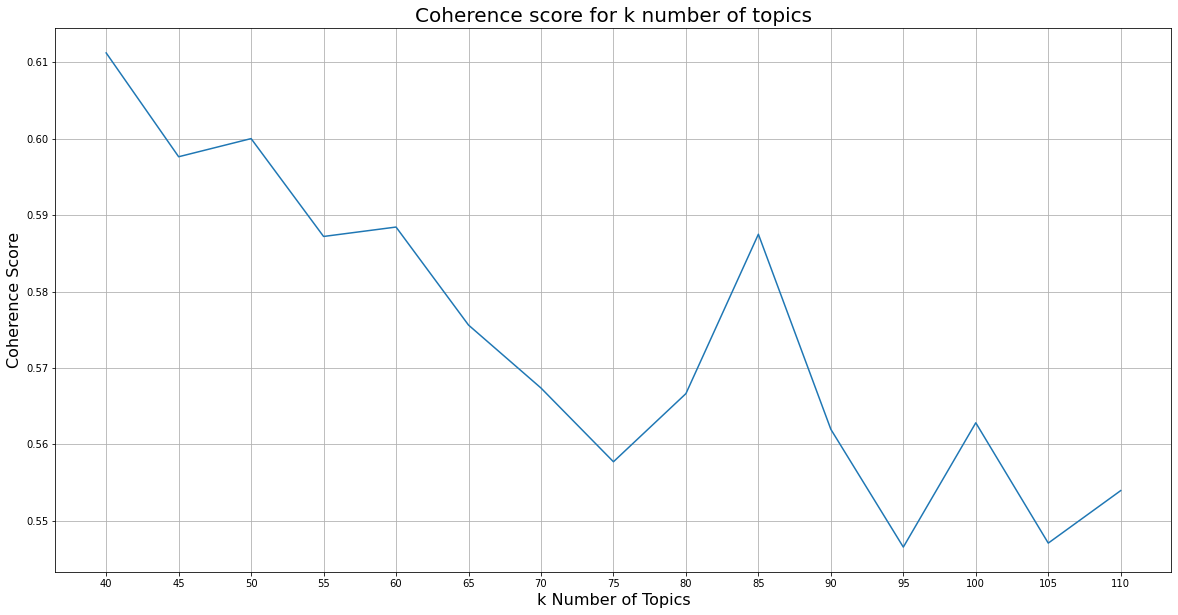

In [9]:
fig, ax = plt.subplots(figsize=(20, 10))

ax.set_title('Coherence score for k number of topics', fontsize=20)
ax.set_xlabel('k Number of Topics', fontsize=16)
ax.set_ylabel('Coherence Score', fontsize=16)

ax.grid('on')

ax.plot(coherence_scores)

plt.xticks(np.arange(len(n_topics_list)), n_topics_list)